# Tugas 1 - Visi Komputer

**Nama:** Teuku Hafiz Izham

**NIM:** 2308107010056

---

Mulai mendeteksi tomat pada 'tomat.jpg'...

Total Tomat Terdeteksi: 4
----------------------------------------------------------------------
No    Status          Kematangan   Detail Warna                  
----------------------------------------------------------------------
1     Hijau           10%          H:82% K:33% P:0% M:0%         
2     Merah Matang    95%          H:0% K:3% P:7% M:90%          
3     Merah Matang    95%          H:0% K:3% P:19% M:85%         
4     Kuning          40%          H:0% K:99% P:0% M:0%          
----------------------------------------------------------------------
Rata-rata Kematangan: 60.0%


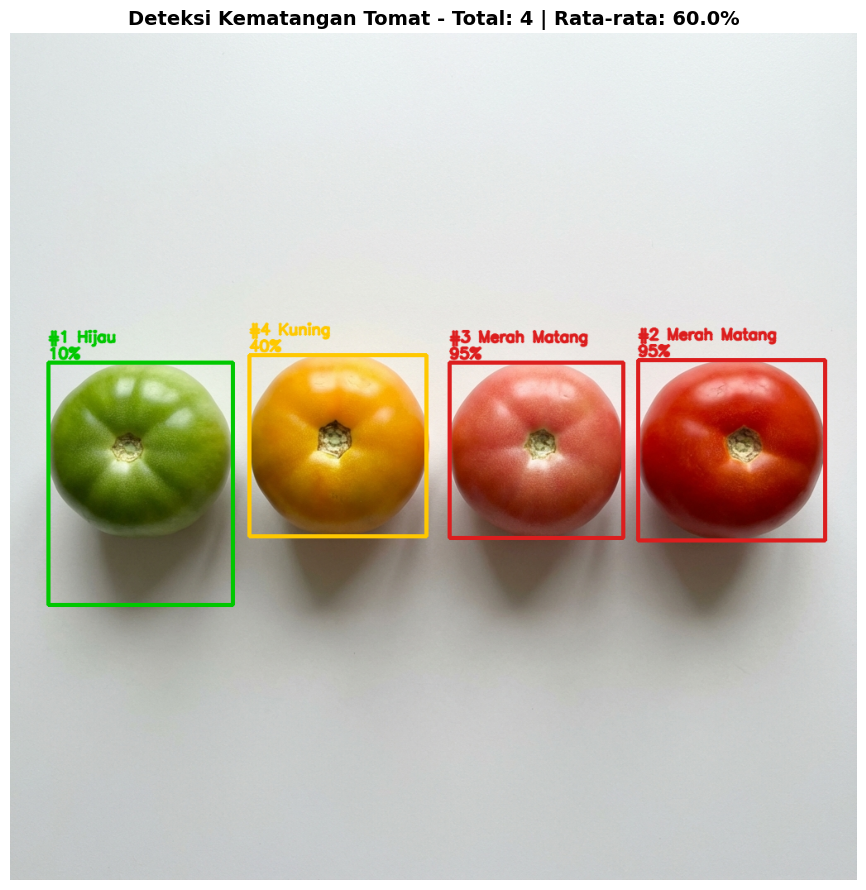

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def detect_tomato_maturity(image_path):
    """
    Mendeteksi tomat dan tingkat kematangannya menggunakan Watershed Algorithm
    dengan threshold yang disesuaikan untuk menghindari deteksi berlebih.
    """
    
    # 1. Cek dan Load Gambar (Tidak ada perubahan)
    if not os.path.exists(image_path):
        print(f"Error: File '{image_path}' tidak ditemukan.")
        return

    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Error: Gagal membaca gambar '{image_path}'.")
        return
        
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    img_blur = cv2.GaussianBlur(img_hsv, (7, 7), 0)

    # 2. Segmentasi Warna (Tidak ada perubahan)
    lower_green = np.array([30, 30, 30])
    upper_green = np.array([80, 255, 255])
    mask_green = cv2.inRange(img_blur, lower_green, upper_green)

    lower_yellow = np.array([15, 50, 50])
    upper_yellow = np.array([35, 255, 255])
    mask_yellow = cv2.inRange(img_blur, lower_yellow, upper_yellow)

    lower_pink = np.array([0, 20, 100])
    upper_pink = np.array([15, 120, 255])
    mask_pink = cv2.inRange(img_blur, lower_pink, upper_pink)

    lower_red1 = np.array([0, 100, 80])
    upper_red1 = np.array([10, 255, 255])
    mask_red1 = cv2.inRange(img_blur, lower_red1, upper_red1)
    lower_red2 = np.array([170, 100, 80])
    upper_red2 = np.array([180, 255, 255])
    mask_red2 = cv2.inRange(img_blur, lower_red2, upper_red2)
    mask_red = cv2.bitwise_or(mask_red1, mask_red2)

    mask_tomato_combined = cv2.bitwise_or(mask_green, mask_yellow)
    mask_tomato_combined = cv2.bitwise_or(mask_tomato_combined, mask_pink)
    mask_tomato_combined = cv2.bitwise_or(mask_tomato_combined, mask_red)

    kernel = np.ones((5,5), np.uint8)
    mask_tomato_combined = cv2.morphologyEx(mask_tomato_combined, cv2.MORPH_CLOSE, kernel)
    mask_tomato_combined = cv2.morphologyEx(mask_tomato_combined, cv2.MORPH_OPEN, kernel)

    # =========================================================================
    # PERBAIKAN UTAMA ADA DI SINI
    # =========================================================================

    # 3. Tentukan "Sure Background"
    sure_bg = cv2.dilate(mask_tomato_combined, kernel, iterations=3)

    # 4. Tentukan "Sure Foreground"
    dist_transform = cv2.distanceTransform(mask_tomato_combined, cv2.DIST_L2, 5)
    
    # --- PERUBAHAN ---
    # Threshold dinaikkan dari 0.4 ke 0.5 untuk membuat seleksi "inti" tomat lebih ketat.
    # Ini akan menghilangkan area noise dan pantulan cahaya dari daftar inti.
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    
    sure_fg = np.uint8(sure_fg)

    # 5. Tentukan "Unknown Region"
    unknown = cv2.subtract(sure_bg, sure_fg)

    # 6. Buat "Markers" dan jalankan Watershed (Tidak ada perubahan)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(img_bgr, markers)

    # =========================================================================

    # 7. Analisis Setiap Tomat yang Sudah Terpisah (Tidak ada perubahan logika)
    tomatoes_data = []
    img_result = img_rgb.copy()
    
    print(f"Mulai mendeteksi tomat pada '{image_path}'...\n")
    tomato_count = 0
    unique_labels = np.unique(markers)
    
    for label in unique_labels:
        if label <= 1:
            continue
        
        mask_single = np.zeros(markers.shape, dtype="uint8")
        mask_single[markers == label] = 255
        
        area = cv2.countNonZero(mask_single)
        # Kita bisa juga menaikkan filter area ini jika perlu, misal menjadi 2000
        if area < 1000: 
            continue
        
        tomato_count += 1

        # Proses kalkulasi warna dan klasifikasi... (Tidak ada perubahan)
        green_in_tomato = cv2.bitwise_and(mask_green, mask_green, mask=mask_single)
        yellow_in_tomato = cv2.bitwise_and(mask_yellow, mask_yellow, mask=mask_single)
        pink_in_tomato = cv2.bitwise_and(mask_pink, mask_pink, mask=mask_single)
        red_in_tomato = cv2.bitwise_and(mask_red, mask_red, mask=mask_single)
        
        total_pixels = area
        green_pixels = cv2.countNonZero(green_in_tomato)
        yellow_pixels = cv2.countNonZero(yellow_in_tomato)
        pink_pixels = cv2.countNonZero(pink_in_tomato)
        red_pixels = cv2.countNonZero(red_in_tomato)
        
        percent_green = (green_pixels / total_pixels) * 100
        percent_yellow = (yellow_pixels / total_pixels) * 100
        percent_pink = (pink_pixels / total_pixels) * 100
        percent_red = (red_pixels / total_pixels) * 100
        
        dominant_color = max([
            (percent_green, 'green'), (percent_yellow, 'yellow'),
            (percent_pink, 'pink'), (percent_red, 'red')
        ])
        
        if dominant_color[1] == 'green' or percent_green >= 60:
            status, color_bbox, maturity_percent = "Hijau", (0, 200, 0), 10
        elif dominant_color[1] == 'yellow' or percent_yellow >= 40:
            status, color_bbox, maturity_percent = "Kuning", (255, 200, 0), 40
        elif dominant_color[1] == 'pink' or (percent_pink >= 30 and percent_red < 50):
            status, color_bbox, maturity_percent = "Merah Muda", (255, 150, 150), 70
        elif dominant_color[1] == 'red' or percent_red >= 40:
            status, color_bbox, maturity_percent = "Merah Matang", (220, 30, 30), 95
        else:
            if percent_yellow > 20 and percent_green > 20:
                status, color_bbox, maturity_percent = "Pecah Warna", (180, 220, 0), 30
            elif percent_red > 20 and percent_yellow > 20:
                status, color_bbox, maturity_percent = "Merah Terang", (255, 100, 50), 85
            else:
                status, color_bbox, maturity_percent = "Transisi", (200, 200, 100), 50
            
        tomatoes_data.append({
            'id': tomato_count, 'maturity_percent': maturity_percent, 'status': status,
            'color_detail': f"H:{percent_green:.0f}% K:{percent_yellow:.0f}% P:{percent_pink:.0f}% M:{percent_red:.0f}%"
        })

        contours, _ = cv2.findContours(mask_single, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(img_result, (x, y), (x+w, y+h), color_bbox, 3)
            
            label_text = f"#{tomato_count} {status}"
            label_perc = f"{maturity_percent:.0f}%"
            
            cv2.putText(img_result, label_text, (x, y - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_bbox, 2, cv2.LINE_AA)
            cv2.putText(img_result, label_perc, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_bbox, 2, cv2.LINE_AA)

    # 8. Tampilkan Output (Tidak ada perubahan)
    print(f"Total Tomat Terdeteksi: {tomato_count}")
    print("-" * 70)
    print(f"{'No':<5} {'Status':<15} {'Kematangan':<12} {'Detail Warna':<30}")
    print("-" * 70)
    
    total_maturity = sum(data['maturity_percent'] for data in tomatoes_data)
    avg_maturity = 0
    if tomato_count > 0:
        avg_maturity = total_maturity / tomato_count
        for data in tomatoes_data:
            print(f"{data['id']:<5} {data['status']:<15} {data['maturity_percent']:.0f}%{' ':<9} {data['color_detail']:<30}")
        print("-" * 70)
        print(f"Rata-rata Kematangan: {avg_maturity:.1f}%")
    else:
        print("Tidak ada tomat yang terdeteksi.")
        
    plt.figure(figsize=(14, 9))
    plt.imshow(img_result)
    plt.axis('off')
    title_text = (f"Deteksi Kematangan Tomat - Total: {tomato_count} | Rata-rata: {avg_maturity:.1f}%" 
                  if tomato_count > 0 else "Deteksi Kematangan Tomat")
    plt.title(title_text, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# --- CARA MENGGUNAKAN ---
if __name__ == "__main__":
    detect_tomato_maturity("tomat.jpg")

Seperti yang terlihat di judul, sistem berhasil mendeteksi Total 4 tomat. Ini adalah poin krusial, karena membuktikan Algoritma Watershed sukses memisahkan objek yang saling menempel. Sistem juga memberikan data praktis, yaitu Rata-rata kematangan sebesar 60%.

Jika kita lihat detailnya dari kiri ke kanan:

- Sistem secara akurat mengidentifikasi tomat pertama sebagai 'Hijau' (10%).
- Tomat kedua sebagai 'Kuning' (40%), ini menunjukkan kemampuan sistem mengenali tahap transisi.
- Dan dua tomat terakhir sebagai 'Merah Matang' (95%).

Secara keseluruhan, output ini membuktikan bahwa sistem ini tidak hanya akurat dalam menghitung, tetapi juga cerdas dalam mengklasifikasikan berbagai tingkat kematangan."